# Aktuelle Limitierungen:

* Inhalte, die mehreren Fächern zugeordnet worden sind, zählen nur zu einem Fach
* Es werden nur Bearbeitungen gezählt
* Folgeevents einer Bearbeitung werden nicht zusammengefasst

In [1]:
import pandas as pd
import mysql.connector

from IPython.display import display, Markdown, HTML

db = mysql.connector.connect(
    host="localhost",
    user="root",
    password="secret",
    port="3306",
    database="serlo"
)

def cached(func):
    cache = dict()
    
    def return_func(arg):
        if (arg in cache):
            return cache[arg]
        else:
            result = func(arg)
            cache[arg] = result
            return result
    
    return return_func

def query(sql):
    c = db.cursor()
    c.execute(sql)
    
    return c.fetchall()

def querySingleton(sql):
    return [ x[0] for x in query(sql) ]

@cached
def getParent(termId):
    return querySingleton("""
        select parent_id from term_taxonomy where id = %s;
    """ % termId)[0]

def getTermName(termId):
    return querySingleton("""
        select term.name from term_taxonomy
        join term on term.id = term_taxonomy.term_id
        where term_taxonomy.id = %s;
    """ % termId)[0]

@cached
def getSubject(termId):
    if int(termId) in [79733, 81317, 20852, 87814, 87827, 85477, 87860, 75049, 76750, 87496, 75678, 91252, 91253]:
        return "Prüfungsbereich Mathematik"
    if int(termId) in [106082]:
        return getTermName(termId)
    
    parent = getParent(termId)
    grandparent = getParent(parent)
    
    if (parent == 106081):
        return getTermName(termId)
    
    return getSubject(parent) if grandparent != None else getTermName(termId)

@cached
def getSubjectFromUuid(uuid):
    taxonomyTerms = querySingleton(f"""
        select term_taxonomy_id from term_taxonomy_entity
        where term_taxonomy_entity.entity_id  = {uuid};
    """)
    
    if len(taxonomyTerms) > 0:
        return getSubject(taxonomyTerms[0])

    parents = querySingleton(f"""
        select parent_id from entity_link
        where entity_link.child_id  = {uuid};
    """)
    
    if len(parents) > 0:
        return getSubjectFromUuid(parents[0])
    
    return None

#display(getSubjectFromUuid(127338))
#display(getSubjectFromUuid(63496))
#display(getSubjectFromUuid(1))
#display(getSubjectFromUuid(170741))
#display(getSubjectFromUuid(167497))

/home/kulla/.local/share/asdf/installs/python/3.9.1/lib/python3.9/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
import json

json.dumps(querySingleton("""
select distinct(entity_link.parent_id ) from event_log join entity_link on entity_link.child_id = event_log.uuid_id where event_log.event_id = 4 and event_log.date > Date("2020-02-01");
"""));

In [3]:
def read_event_log():
    df = pd.read_sql("""
        select event_log.id, event_log.actor_id, event_log.date, user.username, event_parameter_uuid.uuid_id from event_log
        join user on user.id = event_log.actor_id
        join event_parameter on event_parameter.log_id = event_log.id
        join event_parameter_uuid on event_parameter_uuid.event_parameter_id = event_parameter.id
        where event_log.event_id = 5
        and year(event_log.date) > 2018
        and user.username != "Legacy"
    """, db)
    df.set_index("id", inplace=True)
    df.rename(columns={"uuid_id": "uuid"}, inplace=True)
    df["subject"] = df["uuid"].map(getSubjectFromUuid)
    return df

event_log = read_event_log()
event_log.head(10)

,actor_id,date,username,uuid,subject
id,,,,,
252170,95850,2019-01-02 10:35:03,Leo1,127338,Chemie
252172,95850,2019-01-02 10:58:42,Leo1,127338,Chemie
252180,95849,2019-01-02 11:46:55,hernlmax,63496,Chemie
252185,95849,2019-01-02 11:51:49,hernlmax,127428,Chemie
252187,95849,2019-01-02 11:52:47,hernlmax,127428,Chemie
252189,95849,2019-01-02 11:53:00,hernlmax,127428,Chemie
252194,95849,2019-01-02 11:54:28,hernlmax,127428,Chemie
252196,95849,2019-01-02 11:56:19,hernlmax,127355,Chemie
252198,95849,2019-01-02 12:12:57,hernlmax,127432,Chemie


In [4]:
days = 90
edits = 10
cutoff_date = pd.Timestamp.today() - pd.Timedelta(days=days)
#print (cutoff_date)

df1 = event_log[event_log['date'] > cutoff_date] 
df2 = df1.groupby(by = ['subject', 'actor_id'], as_index = False).count()
df3 = df2[df2['uuid'] >= edits]
df3 = df3.drop(['date', 'username', 'uuid'], axis = 1)
df4 = df3.groupby(by = ['subject']).count()
active_authors_df = df4.rename(columns={"actor_id": "active_authors"})
active_authors_df = active_authors_df.sort_values(by = ['active_authors'], ascending=False)
display(Markdown(f"### Anzahl aktiver Autor:Innnen pro Fach"))
active_authors_df

### Anzahl aktiver Autor:Innnen pro Fach

,active_authors
subject,
Mathe,14
Prüfungsbereich Mathematik,7
Community,5
Geographie,3
Informatik,3
Nachhaltigkeit,3
Lerntipps,2
Forensik,1
MatemÃ¡ticas,1


In [5]:
import matplotlib.pyplot as plt

def show(subject=None, lower=10, time_interval=90):
    df = event_log.copy()
    
    if subject:
        df = df[df["subject"] == subject]
        if len(df) == 0:
            return
        
    edits_per_day = compute_edits_per_day_per_user(df)
    df = edits_per_day.rolling(time_interval, min_periods=time_interval).sum()
    df.dropna(inplace=True)
    
    display(Markdown(f"### Plot Anzahl Autor:innen mit Edits >= {lower}"))
    df.apply(lambda x: x.map(lambda y: y >= lower).sum(), axis=1).plot(figsize=(10,10))
    plt.show()
    
    df2 = pd.DataFrame({
        "edits": df.loc[df.index[-1]],
        "edits_before": df.loc[df.index[-1-time_interval]],
    })
    
    count = (df2["edits"] >= lower).sum()
    
    display(Markdown(f"Anzahl Autor:innen mit Edits >= {lower}: {count}"))
    
    display(Markdown(f"### Autor:innen mit aktuellen Edits >= {lower}"))
    d = df2[df2["edits"] >= lower][["edits"]]
    d.sort_values("edits", inplace=True, ascending=False)
    display(d)
    
    display(Markdown(f"### Verlorene Autor:innen mit aktuellen Edits < {lower} und vorher Edits >= {lower}"))
    d = df2[(df2["edits"] < lower) & (df2["edits_before"] >= lower)][["edits"]]
    d.sort_values("edits", inplace=True, ascending=False)
    display(d)
    
    display(Markdown(f"### Neue Autor:innen (Personen, die in den letzten {time_interval} Tagen dazugekommen sind)"))
    df3 = edits_per_day.cumsum()
    df3 = pd.DataFrame({
        "edits": df3.loc[df.index[-1]],
        "edits_before": df3.loc[df.index[-1-time_interval]],
    })
    d = df3[(df3["edits"] > 0) & (df3["edits_before"] == 0)][["edits"]]
    d.sort_values("edits", inplace=True, ascending=False)
    display(d)
    
    display(Markdown(f"### Neue Autor:innen (Personen, die in den letzten {time_interval} Tagen dazugekommen sind) + Edits < {lower}"))
    d = df3[(df3["edits"] < lower) & (df3["edits"] > 0) & (df3["edits_before"] == 0)][["edits"]]
    d.sort_values("edits", inplace=True, ascending=False)
    display(d)

def compute_edits_per_day_per_user(df, since=4*365.25):
    current_date = df["date"].max()
    df = df[df["date"] > current_date - pd.Timedelta(days=since)]
    
    def user_df(username):
        #display(df.head())
        u = df[df["username"] == username].copy()
        u.set_index("date", inplace=True)
        u = u.resample("D").count()[["actor_id"]]
        u.rename(columns={"actor_id": username}, inplace=True)
        return u
    
    df = pd.concat([user_df(u) for u in df["username"].unique()], axis=1)
    df.fillna(0, inplace=True)
    
    return df

#show()

### Plot Anzahl Autor:innen mit Edits >= 10

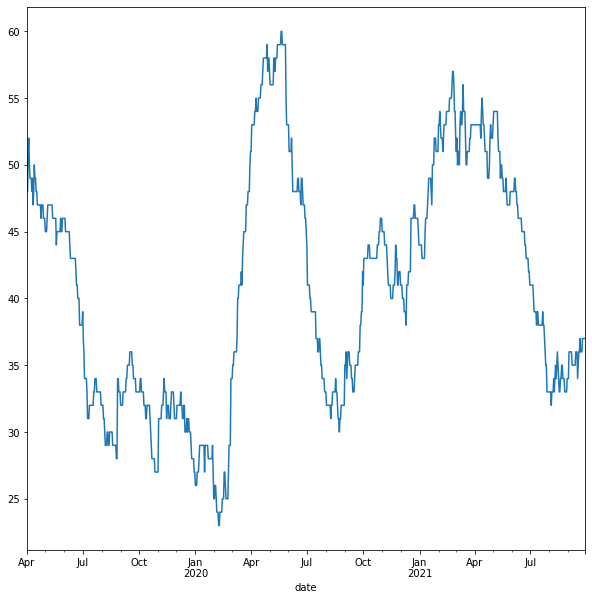

Anzahl Autor:innen mit Edits >= 10: 37

### Autor:innen mit aktuellen Edits >= 10

,edits
LinaMaria,465.0
Kowalsky,421.0
Rami,392.0
Karin,355.0
WandaPaetzold,252.0
kathongi,242.0
Sascha_Lill_95,164.0
ABC19Z,131.0
Gianluca,126.0
Mathewally,119.0


### Verlorene Autor:innen mit aktuellen Edits < 10 und vorher Edits >= 10

,edits
Annika-Hemlein,9.0
BaRockA,6.0
sivakumar,2.0
dal,2.0
wendrock,2.0
sien-lie,1.0
Astor,0.0
lrodriguez,0.0
hwlang,0.0
Flora_Jana,0.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind)

,edits
ABC19Z,131.0
Carina_Faude,59.0
LeonieTrautmann,47.0
Habiba,40.0
senayildiz,21.0
tamara_proebster,21.0
Lavanya,19.0
acarolinabotelho,8.0
lachendesZebra,4.0
randomName23,3.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind) + Edits < 10

,edits
acarolinabotelho,8.0
lachendesZebra,4.0
randomName23,3.0
SimonDoerig187,2.0
Max_,2.0
annacarina,1.0
Natan,1.0
Kopernikus68,1.0
bchij,1.0
krtl,1.0


In [6]:
show()

### Plot Anzahl Autor:innen mit Edits >= 100

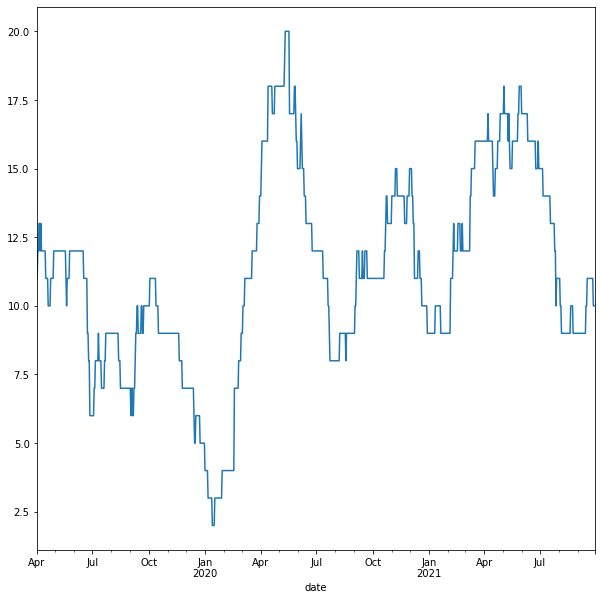

Anzahl Autor:innen mit Edits >= 100: 10

### Autor:innen mit aktuellen Edits >= 100

,edits
LinaMaria,465.0
Kowalsky,421.0
Rami,392.0
Karin,355.0
WandaPaetzold,252.0
kathongi,242.0
Sascha_Lill_95,164.0
ABC19Z,131.0
Gianluca,126.0
Mathewally,119.0


### Verlorene Autor:innen mit aktuellen Edits < 100 und vorher Edits >= 100

,edits
Corinna,96.0
Anton_Zikmund,52.0
MarK97,32.0
Louisa_H,16.0
Annika-Hemlein,9.0
BaRockA,6.0
joshuae,0.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind)

,edits
ABC19Z,131.0
Carina_Faude,59.0
LeonieTrautmann,47.0
Habiba,40.0
senayildiz,21.0
tamara_proebster,21.0
Lavanya,19.0
acarolinabotelho,8.0
lachendesZebra,4.0
randomName23,3.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind) + Edits < 100

,edits
Carina_Faude,59.0
LeonieTrautmann,47.0
Habiba,40.0
senayildiz,21.0
tamara_proebster,21.0
Lavanya,19.0
acarolinabotelho,8.0
lachendesZebra,4.0
randomName23,3.0
SimonDoerig187,2.0


In [7]:
show(lower=100)

### Plot Anzahl Autor:innen mit Edits >= 50

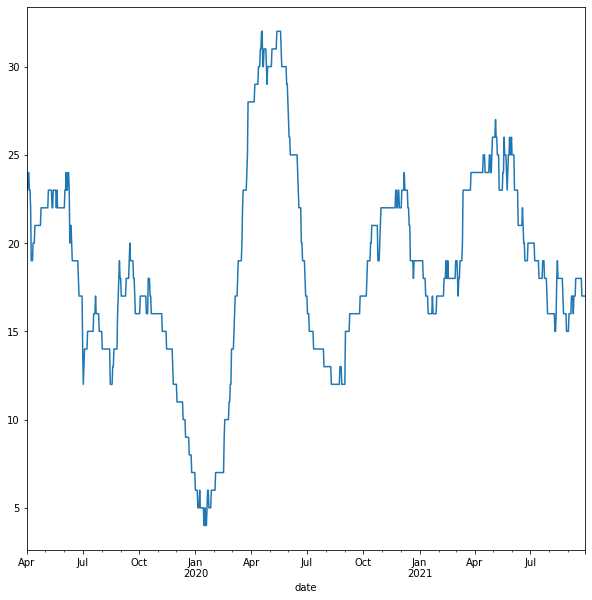

Anzahl Autor:innen mit Edits >= 50: 17

### Autor:innen mit aktuellen Edits >= 50

,edits
LinaMaria,465.0
Kowalsky,421.0
Rami,392.0
Karin,355.0
WandaPaetzold,252.0
kathongi,242.0
Sascha_Lill_95,164.0
ABC19Z,131.0
Gianluca,126.0
Mathewally,119.0


### Verlorene Autor:innen mit aktuellen Edits < 50 und vorher Edits >= 50

,edits
Mathes,40.0
MarK97,32.0
Louisa_H,16.0
metzgaria,15.0
Nish,10.0
Annika-Hemlein,9.0
BaRockA,6.0
dal,2.0
joshuae,0.0
Katrin_K,0.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind)

,edits
ABC19Z,131.0
Carina_Faude,59.0
LeonieTrautmann,47.0
Habiba,40.0
senayildiz,21.0
tamara_proebster,21.0
Lavanya,19.0
acarolinabotelho,8.0
lachendesZebra,4.0
randomName23,3.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind) + Edits < 50

,edits
LeonieTrautmann,47.0
Habiba,40.0
senayildiz,21.0
tamara_proebster,21.0
Lavanya,19.0
acarolinabotelho,8.0
lachendesZebra,4.0
randomName23,3.0
SimonDoerig187,2.0
Max_,2.0


In [8]:
show(lower=50)

In [9]:
event_log["subject"].unique()

array(['Chemie', None, 'Mathe', 'Sandkasten', 'Englisch', 'Community',
       'Nachhaltigkeit', 'Physik', 'Prüfungsbereich Mathematik',
       'Lerntipps', 'Informatik', 'Deutsch als Zweit- und Fremdsprache',
       'Biologie', 'Kommunikation', 'Rechnungswesen', 'Geschichte',
       'Psychologie', 'Wirtschaft', 'Politik', 'mathÃ©matiques',
       'Geographie', 'à®‡à®²à®•à¯\x8dà®•à®£à®®à¯\x8d', 'Medienbildung',
       'Testbereich', 'Latein', 'à®µà®°à®²à®¾à®±à¯\x81',
       'Deutsch als Fremdsprache', 'MatemÃ¡ticas',
       'Conseils pour apprendre', 'Sex Education', 'Musik', 'Forensik',
       'Italienisch', 'community', 'Deutsch'], dtype=object)

## Fach: Mathe

### Plot Anzahl Autor:innen mit Edits >= 10

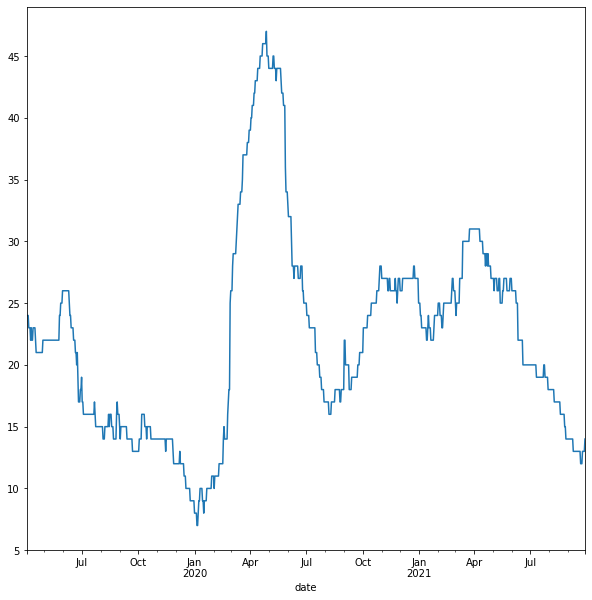

Anzahl Autor:innen mit Edits >= 10: 14

### Autor:innen mit aktuellen Edits >= 10

,edits
Kowalsky,369.0
Karin,329.0
kathongi,224.0
WandaPaetzold,92.0
Mathewally,84.0
Rami,54.0
Anton_Zikmund,43.0
Hersheysoldier,41.0
Mathes,40.0
Habiba,40.0


### Verlorene Autor:innen mit aktuellen Edits < 10 und vorher Edits >= 10

,edits
Annika-Hemlein,7.0
Nish,6.0
Louisa_H,6.0
wendrock,2.0
Flora_Jana,0.0
Katrin_K,0.0
ClaudiaLK,0.0
Daniel-Flueck,0.0
f_mahn02,0.0
Kuddelmuddel,0.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind)

,edits
Habiba,40.0
Carina_Faude,19.0
tamara_proebster,10.0
SimonDoerig187,2.0
Max_,2.0
annacarina,1.0
Natan,1.0
Kopernikus68,1.0
lachendesZebra,1.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind) + Edits < 10

,edits
SimonDoerig187,2.0
Max_,2.0
annacarina,1.0
Natan,1.0
Kopernikus68,1.0
lachendesZebra,1.0


## Fach: Chemie

### Plot Anzahl Autor:innen mit Edits >= 10

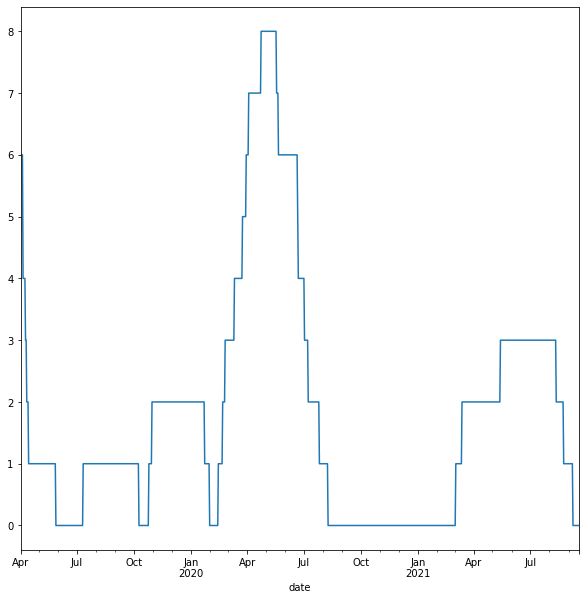

Anzahl Autor:innen mit Edits >= 10: 0

### Autor:innen mit aktuellen Edits >= 10

,edits


### Verlorene Autor:innen mit aktuellen Edits < 10 und vorher Edits >= 10

,edits
WandaPaetzold,5.0
sien-lie,1.0
Rubikscube,0.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind)

,edits
bchij,1.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind) + Edits < 10

,edits
bchij,1.0


## Fach: Physik

### Plot Anzahl Autor:innen mit Edits >= 10

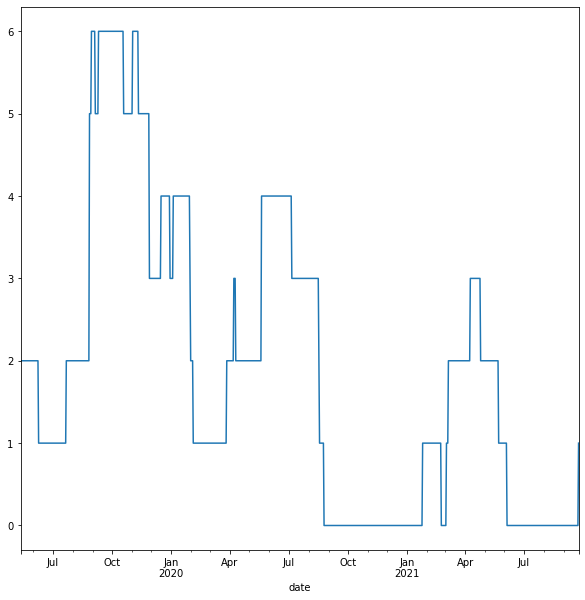

Anzahl Autor:innen mit Edits >= 10: 1

### Autor:innen mit aktuellen Edits >= 10

,edits
tamara_proebster,11.0


### Verlorene Autor:innen mit aktuellen Edits < 10 und vorher Edits >= 10

,edits


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind)

,edits
tamara_proebster,11.0
lachendesZebra,3.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind) + Edits < 10

,edits
lachendesZebra,3.0


## Fach: Nachhaltigkeit

### Plot Anzahl Autor:innen mit Edits >= 10

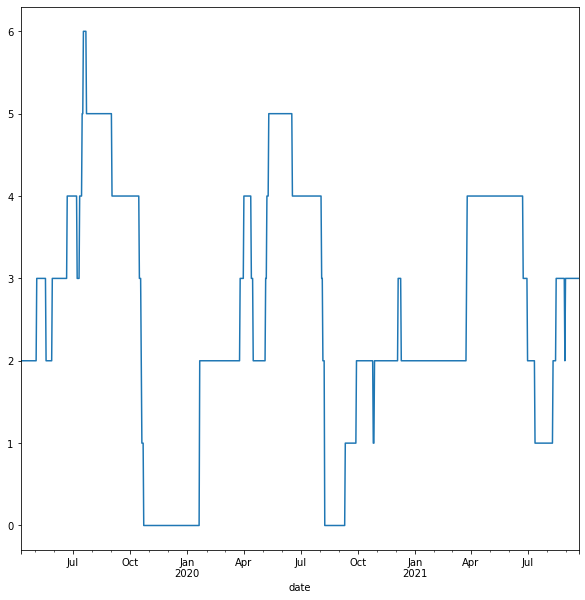

Anzahl Autor:innen mit Edits >= 10: 3

### Autor:innen mit aktuellen Edits >= 10

,edits
Nanami,68.0
Gesine,59.0
Corinna,37.0


### Verlorene Autor:innen mit aktuellen Edits < 10 und vorher Edits >= 10

,edits
WandaPaetzold,0.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind)

,edits


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind) + Edits < 10

,edits


## Fach: Biologie

### Plot Anzahl Autor:innen mit Edits >= 10

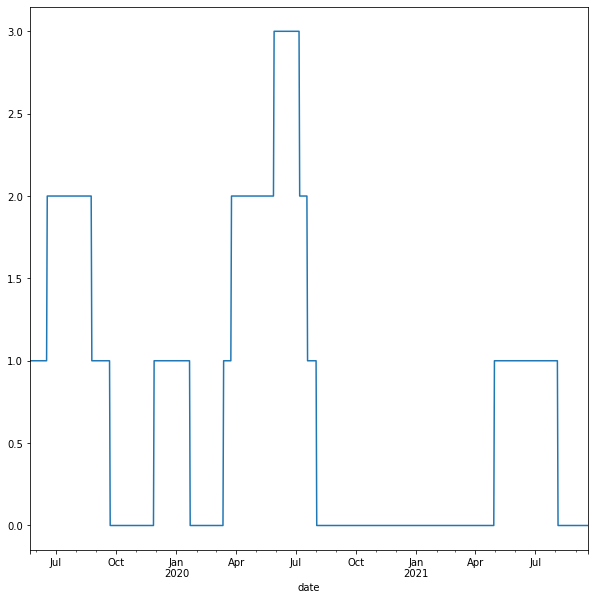

Anzahl Autor:innen mit Edits >= 10: 0

### Autor:innen mit aktuellen Edits >= 10

,edits


### Verlorene Autor:innen mit aktuellen Edits < 10 und vorher Edits >= 10

,edits
WandaPaetzold,3.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind)

,edits


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind) + Edits < 10

,edits


## Fach: Sandkasten

### Plot Anzahl Autor:innen mit Edits >= 10

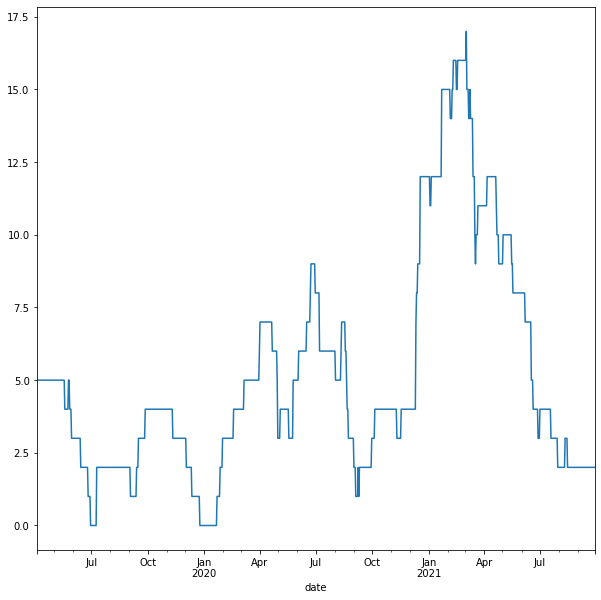

Anzahl Autor:innen mit Edits >= 10: 2

### Autor:innen mit aktuellen Edits >= 10

,edits
Kowalsky,42.0
Kuddelmuddel,12.0


### Verlorene Autor:innen mit aktuellen Edits < 10 und vorher Edits >= 10

,edits
kathongi,0.0
Daniel-Flueck,0.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind)

,edits
Kuddelmuddel,12.0
Anton_Zikmund,9.0
krtl,1.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind) + Edits < 10

,edits
Anton_Zikmund,9.0
krtl,1.0


## Fach: Prüfungsbereich Mathematik

### Plot Anzahl Autor:innen mit Edits >= 10

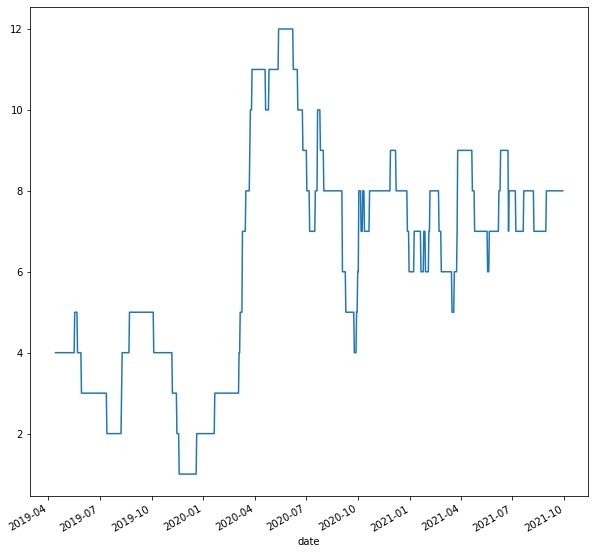

Anzahl Autor:innen mit Edits >= 10: 8

### Autor:innen mit aktuellen Edits >= 10

,edits
Rami,479.0
Gianluca,167.0
WandaPaetzold,152.0
Mathewally,34.0
kathongi,23.0
MelMel,17.0
Kowalsky,14.0
Karin,13.0


### Verlorene Autor:innen mit aktuellen Edits < 10 und vorher Edits >= 10

,edits
MarK97,6.0
Astor,0.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind)

,edits
MelMel,17.0
Carina_Faude,8.0
Louisa_H,7.0
vanessa2021,1.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind) + Edits < 10

,edits
Carina_Faude,8.0
Louisa_H,7.0
vanessa2021,1.0


## Fach: Geographie

### Plot Anzahl Autor:innen mit Edits >= 10

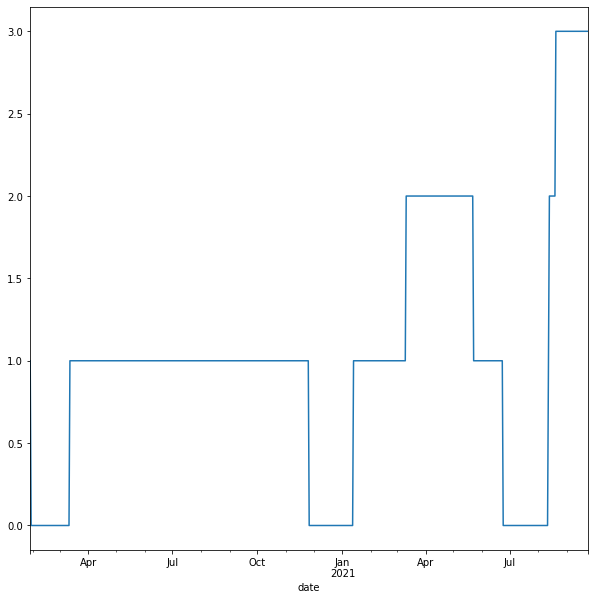

Anzahl Autor:innen mit Edits >= 10: 3

### Autor:innen mit aktuellen Edits >= 10

,edits
ABC19Z,129.0
Carina_Faude,17.0
Nanami,10.0


### Verlorene Autor:innen mit aktuellen Edits < 10 und vorher Edits >= 10

,edits


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind)

,edits
ABC19Z,129.0
Carina_Faude,17.0
Gesine,3.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind) + Edits < 10

,edits
Gesine,3.0


## Fach: Geschichte

### Plot Anzahl Autor:innen mit Edits >= 10

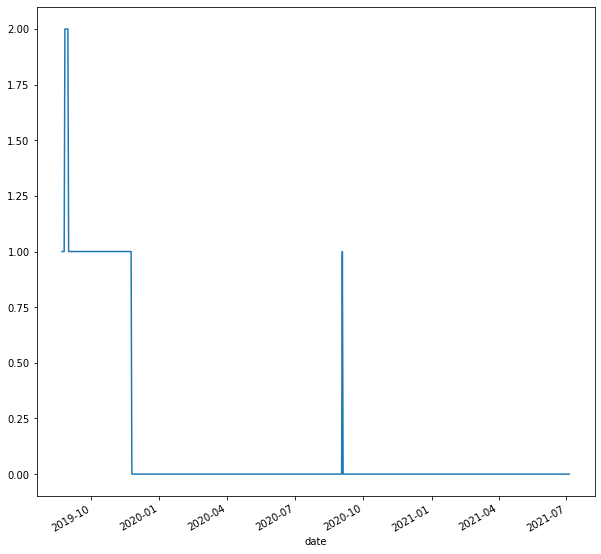

Anzahl Autor:innen mit Edits >= 10: 0

### Autor:innen mit aktuellen Edits >= 10

,edits


### Verlorene Autor:innen mit aktuellen Edits < 10 und vorher Edits >= 10

,edits


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind)

,edits
Carina_Faude,2.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind) + Edits < 10

,edits
Carina_Faude,2.0


## Fach: Community

### Plot Anzahl Autor:innen mit Edits >= 10

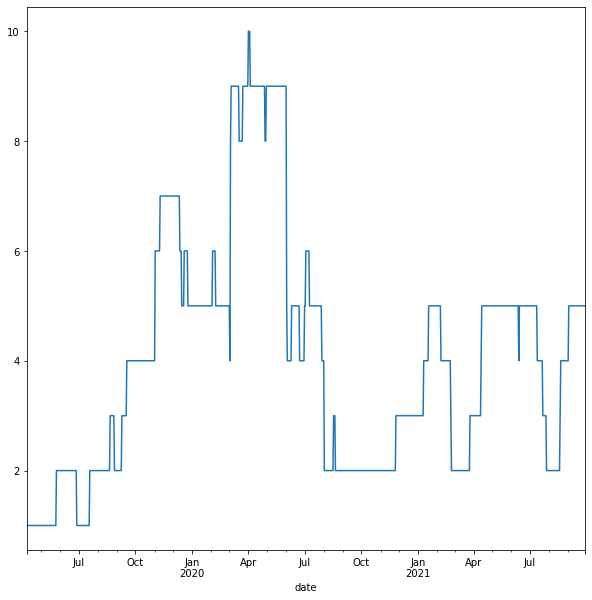

Anzahl Autor:innen mit Edits >= 10: 5

### Autor:innen mit aktuellen Edits >= 10

,edits
Sascha_Lill_95,160.0
LinaMaria,112.0
gruenerBogen,26.0
senayildiz,21.0
Corinna,17.0


### Verlorene Autor:innen mit aktuellen Edits < 10 und vorher Edits >= 10

,edits
kathongi,2.0
lrodriguez,0.0
KerstinPecher,0.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind)

,edits
Sascha_Lill_95,160.0
senayildiz,21.0
acarolinabotelho,8.0
LeonieTrautmann,2.0
randomName23,2.0
ABC19Z,1.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind) + Edits < 10

,edits
acarolinabotelho,8.0
LeonieTrautmann,2.0
randomName23,2.0
ABC19Z,1.0


## Fach: Informatik

### Plot Anzahl Autor:innen mit Edits >= 10

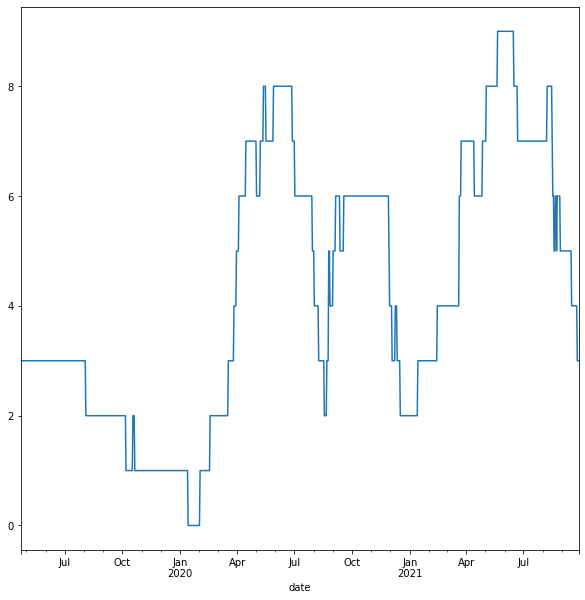

Anzahl Autor:innen mit Edits >= 10: 3

### Autor:innen mit aktuellen Edits >= 10

,edits
opamp,75.0
hxwalther,14.0
Albert_Einstein,13.0


### Verlorene Autor:innen mit aktuellen Edits < 10 und vorher Edits >= 10

,edits
metzgaria,6.0
BaRockA,6.0
WandaPaetzold,0.0
kathongi,0.0
hwlang,0.0
dal,0.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind)

,edits
ABC19Z,1.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind) + Edits < 10

,edits
ABC19Z,1.0


## Fach: Englisch

### Plot Anzahl Autor:innen mit Edits >= 10

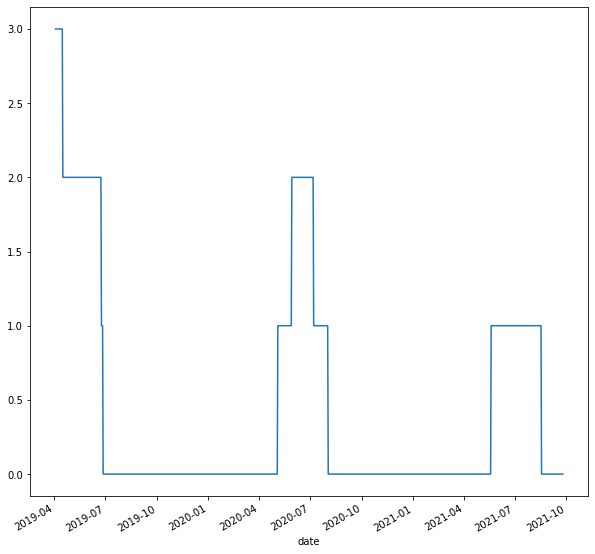

Anzahl Autor:innen mit Edits >= 10: 0

### Autor:innen mit aktuellen Edits >= 10

,edits


### Verlorene Autor:innen mit aktuellen Edits < 10 und vorher Edits >= 10

,edits
Louisa_H,3.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind)

,edits
randomName23,1.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind) + Edits < 10

,edits
randomName23,1.0


In [10]:
for subject in ["Mathe", "Chemie", "Physik",
                  "Nachhaltigkeit", "Biologie", "Sandkasten", "Prüfungsbereich Mathematik",
               "Geographie", "Geschichte", "Community", "Informatik", "Englisch"]:
    
    display(Markdown(f"## Fach: {subject}"))
    show(subject=subject)